In [2]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
import shap
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import warnings
warnings.filterwarnings("ignore")

------

# <b>Sujet</b>

#### - Challenge: "Identification des gaz toxiques" proposé par Bertin Technologies
#### - Lien:" https://challengedata.ens.fr/challenges/156"

Ce challenge proposé par Bertin Technologies vise à améliorer la détection et l'identification des gaz toxiques à l'aide de modèle de ML. Cette détection est essentielle pour assurer la sécurité des personnes, que ce soit dans l'industrie ou en situation de conflit. Les dispositifs portables actuels analysent la composition de l'air en temps réel et déclenchent une alarme en présence de gaz toxiques.


Le jeu de données fourni comprend environ <b>330 000 échantillons</b>, répartis équitablement entre les ensembles d'entraînement et de test. Chaque échantillon contient des mesures de différents capteurs présents dans un dispositif portable de détection de gaz, totalisant <b>14 colonnes</b> :

ID : identifiant unique pour chaque échantillon.
M4 à M7 et M12 à M15 : mesures de deux groupes de capteurs physiquement proches les uns des autres.
S1 à S3 et R : mesures de quatre capteurs complémentaires.
Humidity : humidité absolue (en unités arbitraires), car l'eau influence les mesures.
Les sorties d'entraînement comprennent l'ID et les niveaux d'alarme pour <b>23 classes à détecter</b>, chacune variant entre 0 et 1. Il est à noter que les conditions physiques (humidité, concentrations) dans les données de test diffèrent généralement de celles des données d'entraînement pour un même gaz.


Ce challenge représente un problème de <b>régression supervisée</b>, où l'objectif est de prédire les niveaux d'alarme pour chaque classe de gaz en fonction des mesures des capteurs.

----

# <b>Plan du Notebook</b>

## 1. Visualisation des données
- **1.1 Chargement**
- **1.2 Descriptions**
- **1.3 Visualisation**
- **1.4 Corrélations**

## 2. Modèles ensemblistes
- **2.1 Comparaisons de modèles naïfs**
- **2.2 Finetuning Random Forest**
- **2.3 Finetuning Boosting**

## 3. Travail sur les features
- **3.1 PCA**
- **3.2 Agrégation polynomiales**
- **3.3 1 modèle par variable d'output**
## 4. Deep Learning

## 5. Interpretable Machine Learning
- **5.1 Partial Dependance Plot**
- **5.2 Individual Conditional Expectation**
- **5.3 Shapley Additive Explanations**


-----

## 1. Visualisation des données

### 1.1 Chargement

In [3]:
train_data = pd.read_csv('data/x_train.csv')  
y_data = pd.read_csv('data/y_train.csv')
test_data = pd.read_csv('data/x_test.csv')

### 1.2 Descriptions

In [4]:
print("Number of observations:",train_data.shape[0],"\n" "Number of columns:",train_data.shape[1])

Number of observations: 202933 
Number of columns: 14


Visualisation d'un échantillon :

In [5]:
df_display = train_data.drop(columns=["ID"]).applymap('{:.3f}'.format)
df_display.head(10)

,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
0,0.098,-0.176,-0.086,-0.041,-0.021,0.198,0.055,-0.009,0.002,1.007,1.013,1.001,0.999
1,0.000,-0.066,0.036,0.033,-0.001,2.568,1.883,0.779,0.262,0.971,0.997,1.002,1.013
2,0.000,0.191,0.188,0.144,0.093,-0.147,-0.021,0.040,0.066,1.302,0.905,0.954,0.986
3,0.761,-0.151,-0.084,-0.049,-0.018,0.045,0.102,0.013,0.004,1.014,1.004,1.012,1.009
4,0.108,0.075,0.043,0.026,0.019,-0.056,-0.011,0.010,0.012,0.999,1.005,1.000,1.000
5,0.000,-0.363,-0.168,-0.077,-0.038,1.462,0.535,0.140,0.054,0.936,0.867,0.983,1.004
6,0.000,-0.011,0.029,0.030,0.052,0.145,0.076,0.056,0.060,2.260,0.423,0.902,0.993
7,0.000,0.044,0.034,0.009,0.047,0.143,0.024,0.008,0.004,1.082,1.052,0.990,1.027
8,0.000,-0.202,-0.096,-0.026,0.041,0.371,0.133,0.063,0.061,1.602,0.822,0.934,1.000
9,0.000,-3.131,-2.283,-1.301,-0.381,0.740,0.281,0.137,0.132,0.944,0.687,0.964,0.995


Quelques statistiques descriptives du dataset :

In [6]:
df_display = df_display.astype(float)
summary_stats = df_display.agg({x: ['count', 'median', 'mean', 'std', 'skew', 'kurtosis', 'min', 'max'] for x in df_display.columns}).applymap('{:.2f}'.format)
summary_stats.head(15)

,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
count,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00
median,0.09,-0.00,0.02,0.02,0.01,0.16,0.07,0.04,0.03,1.01,0.93,0.99,1.00
mean,0.23,-0.30,-0.25,-0.16,-0.05,0.89,0.45,0.18,0.08,1.19,0.86,1.01,1.00
std,0.34,1.42,1.25,0.85,0.36,2.43,1.58,0.82,0.39,1.83,0.31,1.17,0.02
skew,1.22,-4.23,-4.73,-5.47,-6.18,4.33,7.51,11.24,13.36,17.71,4.95,33.13,-5.28
kurtosis,-0.28,23.62,29.13,38.93,50.32,22.58,72.89,153.37,211.66,357.07,78.22,1248.83,43.06
min,0.00,-13.02,-11.85,-9.12,-4.17,-2.83,-0.79,-0.22,-0.15,0.02,0.03,0.15,0.71
max,0.96,2.54,2.87,2.00,0.84,28.25,28.71,20.51,10.71,48.03,6.63,55.70,1.06


### 1.3 Visualisation

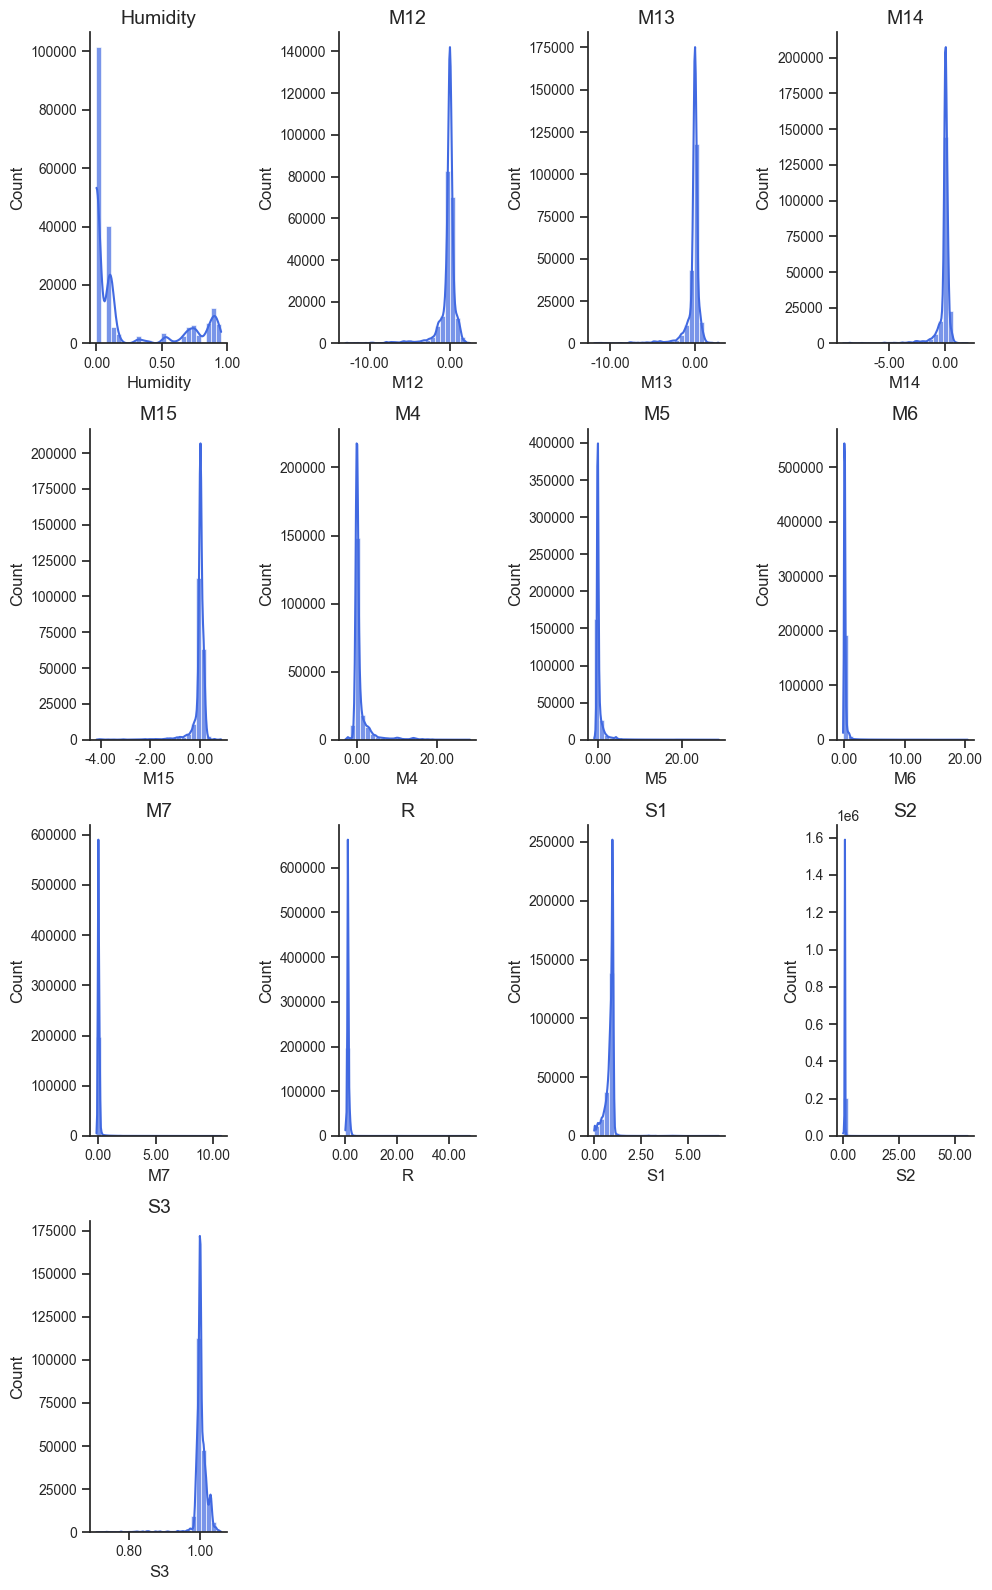

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

params = {
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "font.size": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [6, 6]
}
plt.rcParams.update(params)

def tick_fmt(number, pos):
    return f"{number:,.2f}"

num_vars = len(df_display.columns)
num_cols = 4
num_rows = -(-num_vars // num_cols)

plt.figure(figsize=(10, 4 * num_rows))

for i, var in enumerate(df_display.columns):
    plt.subplot(num_rows, num_cols, i + 1)

    sns.histplot(df_display[var], bins=25, color="royalblue", alpha=0.7, kde=True)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(tick_fmt))
    plt.title(var)

plt.tight_layout()
plt.show()

### 1.4 Corrélations

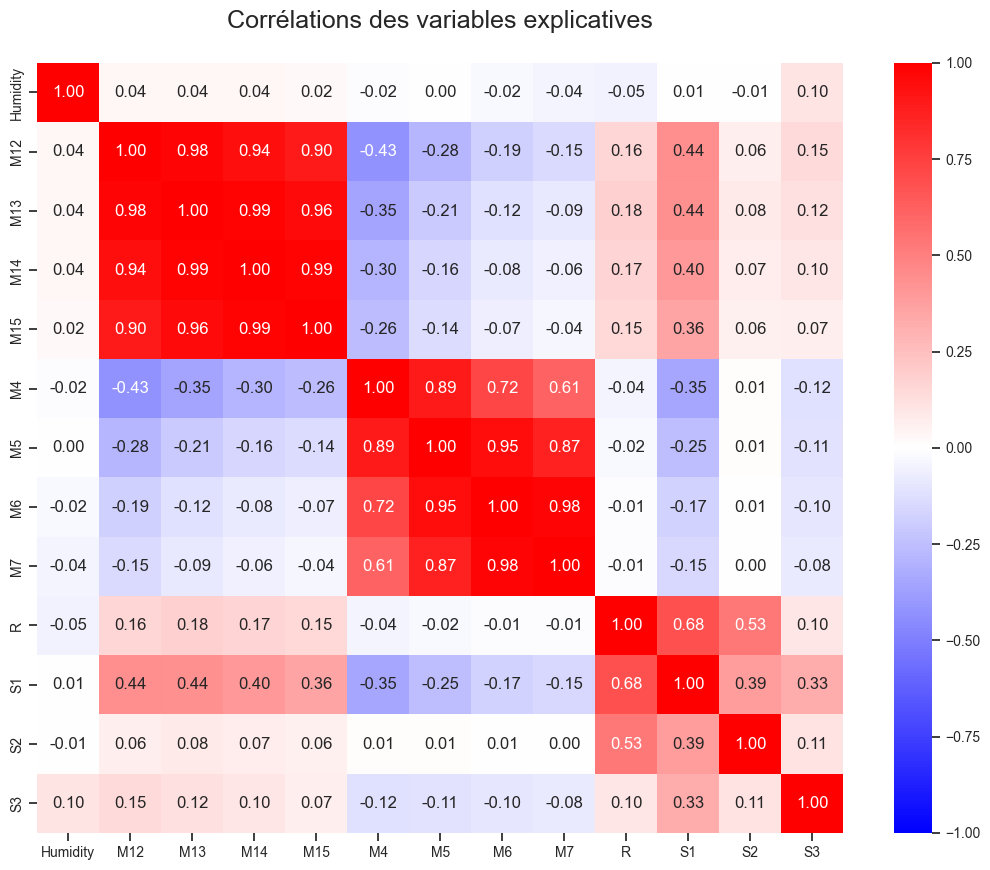

In [8]:
correlations = df_display.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(correlations, annot=True, cmap='bwr', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 12})
plt.title('Corrélations des variables explicatives\n', fontsize=18)
plt.show()

-> On observe des clusters de corrélation : le groupe M12 à M15, le groupe de M4 à M7 ainsi que le groupe R, S1, S2 présentent des fortes corrélations entre variables.

------

## 2. Modèles ensemblistes

Définition de la fonction de coût définie dans l'énoncé du problème :

In [9]:
def custom_weighted_rmse(y_true, y_pred):
    weights = np.where(y_true < 0.5, 1, 1.2)
    error_per_class = weights * (y_true - y_pred) ** 2
    mean_error = np.mean(error_per_class)
    return np.sqrt(mean_error)

custom_scorer = make_scorer(custom_weighted_rmse, greater_is_better=False)

Split données entrainement & validation :

In [10]:
X = train_data.drop(columns=['ID'])
y = y_data.drop(columns=['ID'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1 Comparaisons de modèles naïfs

On applique un standard scaler pour mettre à l'échelle les données. 

Cette normalisation est nécessaire pour certains modèles, d'autre l'applique naturellement (Random Forest par exemple) :

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

On cherche à tester sur un grand nombre de modèle afin d'avoir des premiers résultats sur leurs pertinence dans le cadre de notre étude.

Ces modèles ont les paramètres par défaut, ce qui est loin d'être optimal mais cela permet d'avoir une première idée.

In [12]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for model in models.values() :
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred) 
    custom_rmse = custom_weighted_rmse(y_val, y_pred)
    res.append([model.__class__.__name__,custom_rmse, mse,r2,])

In [ ]:
res = pd.DataFrame(res,columns=["model","custom_rmse","mse","r2"]).sort_values(by="custom_rmse",ascending=True)
res = res.iloc[:, 1:].round(4)

,model,custom_rmse,mse,r2
6,RandomForestRegressor,0.009352,0.000083,0.997203
5,DecisionTreeRegressor,0.015167,0.000215,0.993188
7,KNeighborsRegressor,0.016943,0.000271,0.990021
0,XGBRegressor,0.023383,0.000509,0.946988
1,LinearRegression,0.178304,0.028143,0.272863
2,Ridge,0.178305,0.028143,0.272864
3,Lasso,0.217702,0.041588,0.043445
4,ElasticNet,0.217702,0.041588,0.043445


Le meilleur modèle semble etre le Random Forest Regressor. 

On va donc essayer d'en optimiser les paramètre pour affiner le fit.

### 2.2 Finetuning Random Forest

On va commencer par utiliser un modèle de Random Forest simple que l'on va évaluer :

In [ ]:
model_rf = RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=0.01, min_samples_leaf=30, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
rmse = round(custom_weighted_rmse(y_val, y_pred),3)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.12


On optimise maintenant les paramètres du Random Forest à l'aide d'un GridSearch :

In [15]:
param_grid = {
    'n_estimators': [11,12,13],
    'max_depth': [15,20],
    'min_samples_split': [0.01],
    'min_samples_leaf': [30]
}
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

Meilleurs hyperparamètres : {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 0.01, 'n_estimators': 12}


Sur les données de validation :

In [16]:
y_pred = best_model.predict(X_val)
best_mse = round(mean_squared_error(y_val, y_pred),4,)
best_r2 = round(r2_score(y_val, y_pred),4)
custom_mse = round(custom_weighted_rmse(y_val, y_pred),4)
print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")
print(f"Custom MSE sur les données de validation : {custom_mse}")

Best Mean Squared Error: 0.0076
Best R^2 Score: 0.7259
Custom MSE sur les données de validation : 0.0913


## 3. Travail sur les features

### 3.1 PCA

L'objectif de la PCA est de réduire de dimensionnalité en transformant les données en un nouvel espace où les nouvelles variables, appelées composantes principales, sont linéairement décorrélées.

Naturellement, après avoir analysé la corrélation entre les variables en section 1.4, nous pensons qu'il est pertinent d'utiliser une PCA car le dataset présente un grand nombre de variables très corrélées.

In [17]:
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

model_rf_pca = RandomForestRegressor(n_estimators=12, max_depth=20, min_samples_split=0.01, min_samples_leaf=30, random_state=42)
model_rf_pca.fit(X_train_pca, y_train)
y_pred_pca = model_rf_pca.predict(X_val_pca)

rmse_pca = round(custom_weighted_rmse(y_val, y_pred_pca), 2)
print(f"Erreur quadratique moyenne pondérée (RMSE) avec PCA : {rmse_pca}")
rmse_no_pca = round(custom_weighted_rmse(y_val, y_pred), 2)
print(f"Erreur quadratique moyenne pondérée (RMSE) sans PCA : {rmse_no_pca}")

Erreur quadratique moyenne pondérée (RMSE) avec PCA : 0.12
Erreur quadratique moyenne pondérée (RMSE) sans PCA : 0.09


### 3.2 Agrégation polynomiales

Avec le PolynomialFeatures, on cherche à enrichir les données en ajoutant des caractéristiques polynomiales (ici d'odre 2) et les interactions entre paires de caractéristiques, pour permettre au modèle de capturer des relations non linéaires et ainsi améliorer leurs performances prédictives.

On définit le dataset avec les relations polynomiales :

In [18]:
poly = PolynomialFeatures(degree=2)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (162346, 13)
X_train_poly.shape: (162346, 105)


On test à nouveaux tous les modèles avec les polynomial features :

In [19]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=0.01, min_samples_leaf=30, random_state=42),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for model in models.values() :
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_val_poly)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred) 
    custom_rmse = custom_weighted_rmse(y_val, y_pred)
    res.append([model.__class__.__name__,"Polynomial Features",custom_rmse, mse,r2,])

In [20]:
res = pd.DataFrame(res,columns=["model","Type","custom_rmse","mse","r2"]).sort_values(by="custom_rmse",ascending=True)
display(res)

,model,Type,custom_rmse,mse,r2
5,DecisionTreeRegressor,Polynomial Features,0.018340,0.000312,0.988251
7,KNeighborsRegressor,Polynomial Features,0.019814,0.000368,0.986720
0,XGBRegressor,Polynomial Features,0.020608,0.000395,0.948205
6,RandomForestRegressor,Polynomial Features,0.117690,0.012452,0.612993
1,LinearRegression,Polynomial Features,0.149502,0.019998,0.482415
2,Ridge,Polynomial Features,0.149709,0.020049,0.481192
4,ElasticNet,Polynomial Features,0.217137,0.041380,0.051383
3,Lasso,Polynomial Features,0.217702,0.041588,0.043445


### 3.3 1 modèle par variable d'output

Notre problème est un problème de regression un peu particulier.

En effet, on cherche à prédire 24 variables de sortie.
Ci dessous on cherche à prédire une colonne à la fois pour voir si le modèle est plus précis en se concentrant sur une seule variable puis en les agrégeant.

Le calcul étant assez long, on ne test que deux modèles :

In [22]:
models = {
    'XGBoost' : XGBRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
}

res = list()
for model in models.values():
    multi_target_model = MultiOutputRegressor(model)
    multi_target_model.fit(X_train, y_train)
    y_pred = multi_target_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    custom_rmse = custom_weighted_rmse(y_val, y_pred)
    res.append([model.__class__.__name__, custom_rmse, mse, r2])

In [23]:
res = pd.DataFrame(res,columns=["model","custom_rmse","mse","r2"]).sort_values(by="custom_rmse", ascending=True)
res

,model,custom_rmse,mse,r2
1,RandomForestRegressor,0.011905,0.000132,0.995051
0,XGBRegressor,0.023270,0.000504,0.990297


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Interpretable Machine Learning

On présente dans la section qui suit quelques visualisations qui permetent de donner des informations sur le modèle.

## Partial Dependence Plot (PDP)

<u>Objectif :</u>

Le Partial Dependence Plot permet de visualiser comment une caractéristique influence les prédictions d'un modèle, en moyennisant l'effet des autres caractéristiques. Il aide à comprendre l'impact global d'une variable sur le modèle, facilitant ainsi l'interprétation des résultats.

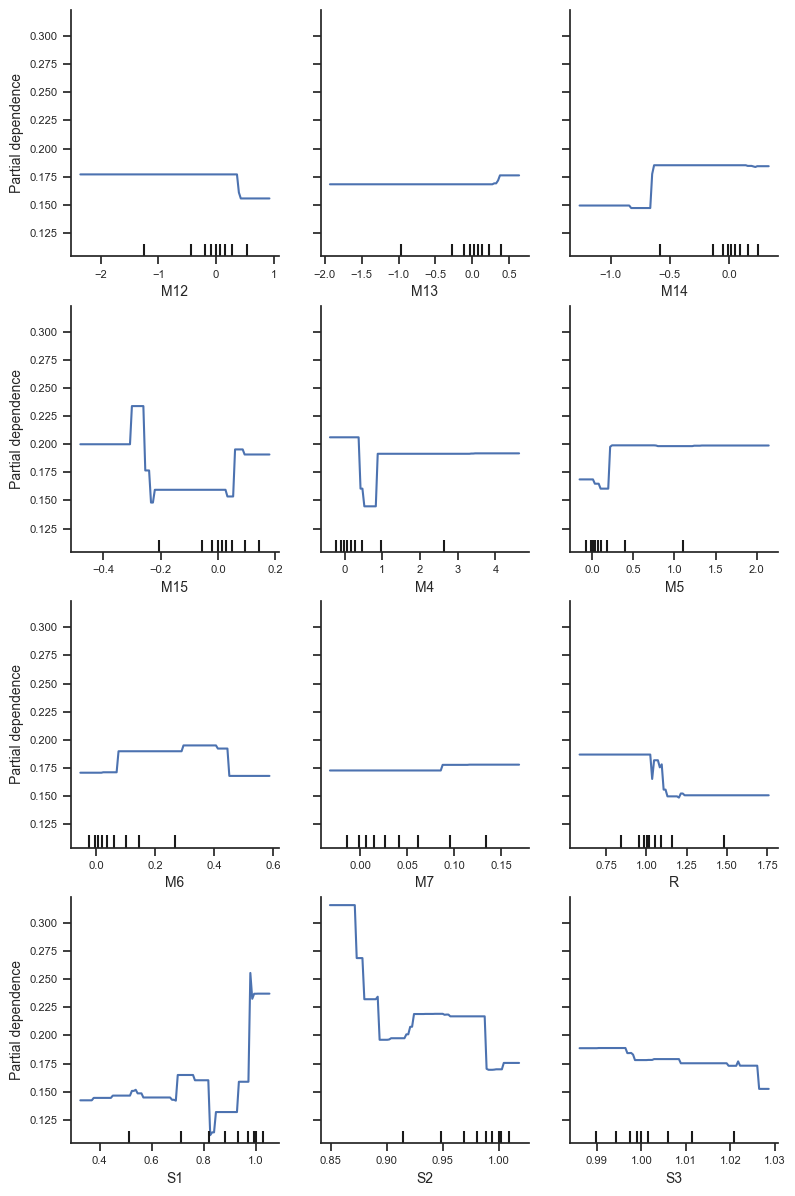

In [ ]:
params = {
    "axes.labelsize":10,
    "axes.titlesize":12,
    "font.size":8,
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    'figure.figsize':[8,12]
}
plt.rcParams.update(params)
PartialDependenceDisplay.from_estimator(model_rf, X_train,
                                        [1,2,3,4,5,6,7,8,9,10,11,12],
                                        feature_names=X_train.columns,
                                        n_jobs=-2)
plt.tight_layout()
plt.show()

-> On observe que pour certaines caractéristiques comme M15 et M6 des variations modérées, indiquant un impact limité mais notable sur les prédictions. D'autres, comme M4 et R, montrent des courbes relativement plates, suggérant un effet marginal évoluant peu en fonction des valeurs de la variable. En revanche, des caractéristiques telles que S1 ou S2 présentent des fluctuations plus prononcées, indiquant un impact significatif. Notamment, S2 montre une forte influence sur les prédictions pour les valeurs plus faibles, tandis que cette influence diminue pour les valeurs plus élevées. La variable S1 semble avoir l'effet inverse, une influence importante pour des valeurs plus élevées mais faible pour des valeurs en dessous de 1.

## Individual Conditional Expectation (ICE)

<u>Objectif :</u>

L'Individual Conditional Expectation est une technique utilisée pour visualiser l'impact d'une caractéristique spécifique sur les prédictions d'un modèle pour chaque instance individuelle dans un ensemble de données. Contrairement à la Partial Dependence Plot , qui montre l'effet moyen d'une caractéristique sur les prédictions, l'ICE trace une courbe pour chaque observation, illustrant comment la prédiction change lorsque la valeur de la caractéristique varie. Cela permet d'identifier des variations ou des comportements spécifiques à certaines instances.

<u>Remarque dans notre exercice :</u>

Comme notre exercice est un exercice de regression à sorties multiples (on prédit plusieurs colonnes), on spécifie la variable de sortie pour laquelle on souhaite visualiser les dépendances des variables explicatives. On utilise l'argument "target" pour sélectionner la variable expliquée cible, ici 0 pour l'exemple mais on peut répéter l'analyse pour chacune des variables à expliquer.

Comme le dataset est de très grande taille, on limite l'analyse à 10.000 lignes pour éviter les problèmes d'allocation de mémoire.

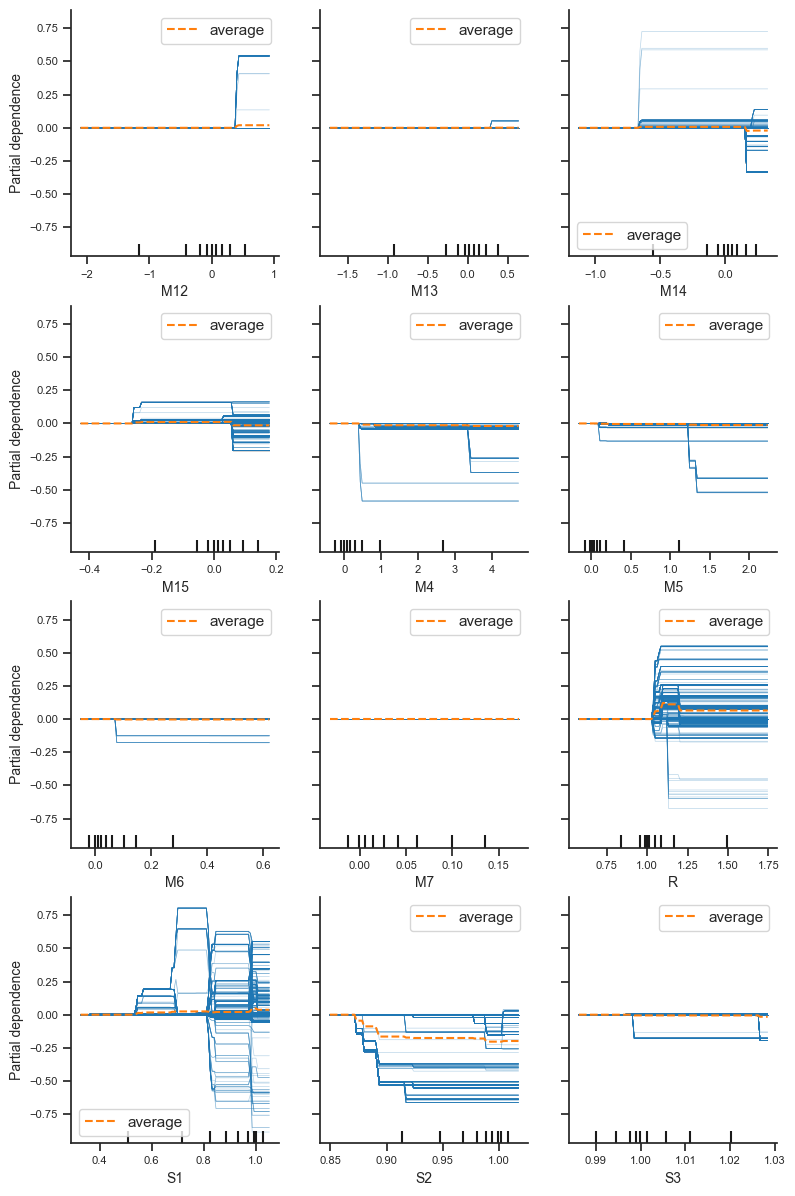

In [ ]:
params = {
    "axes.labelsize":10,
    "axes.titlesize":12,
    "font.size":8,
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    'figure.figsize':[8,12]
}
plt.rcParams.update(params)
PartialDependenceDisplay.from_estimator(model_rf, X_train.iloc[:10000, :],
                                        [1,2,3,4,5,6,7,8,9,10,11,12],
                                        feature_names=X_train.columns,
                                        kind="both",
                                        centered=True,
                                        n_jobs=-2,
                                        target=1)
plt.tight_layout()
plt.show()

-> Pour les caractéristiques M6 et M7 par exemple, les courbes ICE sont relativement plates, indiquant un impact limité sur les prédictions, avec des moyennes proches de zéro. En revanche, R ou S1 montrent des variations plus prononcées, avec des courbes ICE qui divergent significativement de la moyenne, suggérant que ces caractéristiques ont un impact plus important et variable sur les prédictions.
S1 montre une forte dispersion des courbes ICE, indiquant que cette caractéristique a un impact très variable selon les instances. S2 montrent des fluctuations notables, suggérant des influences spécifiques selon les valeurs des caractéristiques mais s'étalant sur plusieurs niveaux regroupés : plusieurs courbes vers 0 et plusieurs courbes vers -0.5 suggérant des groupes d'individus présentant des caractéristiques similaires d'un point de vue de la mesure S2.

## Shapley Additive Explanations (SHAP)

<u>Objectif :</u>

SHAP est une méthode qui aide à comprendre comment chaque caractéristique influence les prédictions d'un modèle. Elle attribue une valeur à chaque caractéristique pour montrer son importance dans la prédiction, ainsi pour chaque variables explicative on observe la répartition de l'importance des observations.

<u>Remarque dans notre exercice :</u>

Comme notre exercice est un exercice de regression à sorties multiples (on prédit plusieurs colonnes), on spécifie la variable de sortie pour laquelle on souhaite visualiser les dépendances des variables explicatives, ici 0 pour l'exemple mais on peut répéter l'analyse pour chacune des variables à expliquer.

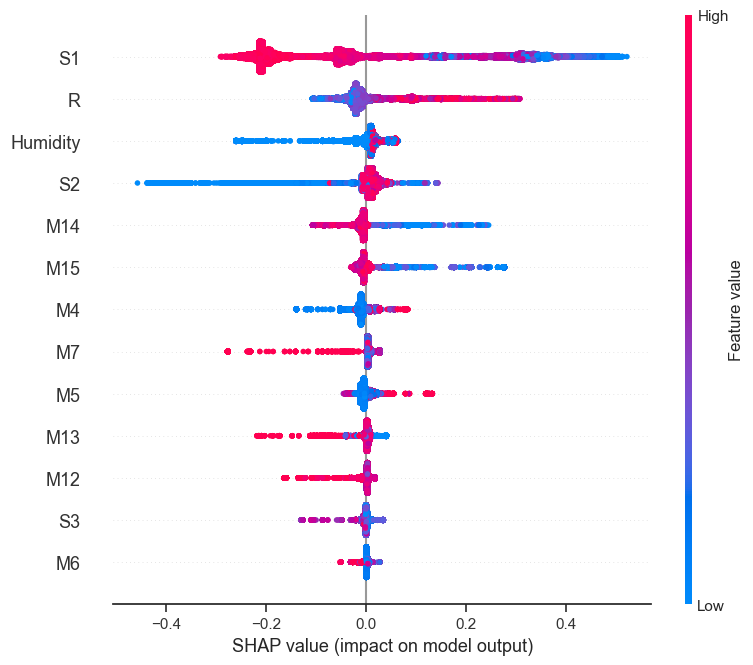

In [ ]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train)
shap_values_for_output = shap_values[:, :, 0]
shap.summary_plot(shap_values_for_output, X_train)

-> Ce graphique SHAP illustre l'influence des différentes caractéristiques sur les prédictions d'un modèle. La caractéristique "S1" se distingue par un impact positif significatif, avec des valeurs élevées (en rouge) qui augmentent fortement la prédiction. En revanche, "R" et "S2" présentent des impacts variés, avec des importances de prédiction qui diffèrent en fonction desvaleurs SHAP positives et négatives, indiquant que leur influence dépend de leur valeur spécifique (valeurs positives pour "R" et valeurs proches de 0 pour "S2").
Les caractéristiques comme "M14" et "M15" montrent des impacts plus modérés, avec des distributions de valeurs SHAP plus concentrées autour de zéro.

-----

### <b>Annexe</b> : prédiction pour submit une solution sur le site

In [ ]:
X_test = test_data.drop(columns=['ID'])
X_test_scaled   = scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)

In [ ]:
test_pred = best_model.predict(X_test_poly)
output = pd.DataFrame(test_pred, columns=[f'c{i}' for i in range(1, 24)])
# Ajouter la colonne "ID" au début
output.insert(0, 'ID', test_data['ID'])
output.to_csv('predictions/best_prediction_Poly.csv', index=False)